In [ ]:
%pip install sympy

<h2>Importación</h2>

In [ ]:
import numpy as np
import math
import ansys.math.core.math as pymath
import sympy
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

<h1>->Optimización de silueta NACA 2412 </h>

<h2>1. Ingreso de coordenadas [x,y] para extrados e intrados</h2>

Nota: Se elimino el valor de conexión entre extrados e intrados [0,0]

-> Extrados

In [ ]:
xe=[1.0000, 0.975752, 0.795047, 0.500587, 0.203313, 0.022051]
ye=[0.00000, 0.005092,0.03776, 0.0723030, 0.072945, 0.028152]
print("xe","\t","ye")
matrix_length = len(xe)
for i in range(matrix_length):
    print(f"{xe[i]:.3f}","\t",f"{ye[i]:.3f}") 

-> Intrados

In [ ]:
xi=[0.026892, 0.208902,0.499413,0.792738,0.975305,1]
yi=[-0.023408,-0.042343,-0.033414,-0.014999,-0.001896,0]
print("xi","\t","yi")
matrix_length = len(xi)
for i in range(matrix_length):
    print(f"{xi[i]:.3f}","\t",f"{yi[i]:.3f}") 

<h2>2. Sistema de ecuaciones para encontrar los coeficientes "a" del extrados e intrados</h2>

->Extrados

In [ ]:
A = np.array([[pow(xe[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(ye)
sol_e = np.linalg.solve(A, b)
print(sol_e)

-> Intrados

In [ ]:
A = np.array([[pow(xi[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(yi)
sol_i = np.linalg.solve(A, b)
print(sol_i)

<h2>NOTA: aquí se verifican los resultados posteriores para y"emáx, y"imin, x_emax & x_imin

-> Calcular X_emax 


In [ ]:
xee = sympy.symbols('xee')
fe = sum(sol_e[i]*xee**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fe, xee)

sol = sympy.solve(dy, xee)

def is_sol(xee):
    if sympy.im(xee) != 0:
        return False
    if xee < 0 or xee > 1:
        return False
    return True

x_eemax =float([xee for xee in sol if is_sol(xee)][0])
print("x_eemax=",x_eemax)
display(fe)

-> Calcular X_imax 

In [ ]:
xii = sympy.symbols('xii')
fi = sum(sol_i[i]*xii**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fi, xii)

sol = sympy.solve(dy, xii)

def is_sol(xii):
    if sympy.im(xii) != 0:
        return False
    if xii < 0 or xii > 1:
        return False
    return True

x_imin = float([xii for xii in sol if is_sol(xii)][0])
print("x_imin=",x_imin)
display(fi)



<h2>3. Calculo de los parametros del perfil<\h2>

-> Variables simbolicas, no son numeros

In [ ]:
y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax, x_imax, dy_emax, dy_imax, r_ba=sympy.symbols("y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax,x_imax, dy_emax, dy_imax, r_ba")

In [ ]:
ae=sympy.symbols("ae:6")
ai=sympy.symbols("ai:6")


-> Iteradores

In [ ]:
k=sympy.symbols("k",integer=True)

-> Ecuaciones a resolver

In [ ]:
eq1=sympy.sqrt(2*r_ba)+ai[0]
#extrados
eq2 =sum([ae[k-1]*pow(x_emax, k-0.5) for k in range(1, 7)])-y_emax
eq3=sum([(k-0.5)*ae[k-1]*pow(x_emax, k-1.5) for k in range(1, 7)])
eq4=sum([(k-1.5)*(k-0.5)*ae[k-1]*pow(x_emax, k-2.5) for k in range(1, 7)])-dy_emax
eq5=sum([ae[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs    #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq6=sum([(k-0.5)*ae[k-1] for k in range(1, 7)])-sympy.tan((2*alpha-beta)/2)
#intrados 
eq7=sum([ai[k-1]*pow(x_imax, k-0.5) for k in range(1, 7)])-y_imax
eq8=sum([(k-0.5)*ai[k-1]*pow(x_imax, k-1.5) for k in range(1, 7)])
eq9=sum([(k-1.5)*(k-0.5)*ai[k-1]*pow(x_imax, k-2.5) for k in range(1, 7)])-dy_imax
eq10=sum([ai[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs   #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq11=sum([(k-0.5)*ai[k-1] for k in range(1, 7)])-sympy.tan((2*alpha+beta)/2)
#Fueron igualadas a 0 para crear el sistema de solución con ayuda de sympy

-> Impresión y verificación 

In [ ]:
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display(eq6)
display(eq7)
display(eq8)
display(eq9)
display(eq10)
display(eq11)

<h2>->Simplificación con suposición

In [ ]:
eq=[eq1, eq2,  eq4 , eq6, eq7, eq9, eq11] #Se crea un grupo para todas las ecuaciones, NOTA SE ELIMINA 3,5,8, 10 PORQUE VALEN 0!!!!
for i in range(len(eq)):
    for j in range(len(sol_e)):
        eq[i]=eq[i].subs(ae[j],sol_e[j])
    for j in range(len(sol_i)):
        eq[i]=eq[i].subs(ai[j],sol_i[j])
    eq[i]=eq[i].subs({ 'x_emax':x_eemax, 'x_imax':x_imin, 'deltay_bs':0, 'y_bs':0 }) #con derivadas se determina rapidamente estos valores para ayudar al solver

for e in eq:
    display(e) #todo esta igualado a cero

<h2>->Solver </h2>

In [ ]:
def sistema_ecuaciones(x):
    eqv = list(map(lambda eq: float(eq.subs({  #programación funcional 
       'r_ba': x[0],
       'y_emax': x[1],
       'dy_emax': x[2],
       'alpha': x[3],
       'beta':x[5],
       'dy_imax': x[6],
       'y_imax':x[4]
    })),eq))

    return eqv


In [ ]:
# Valores iniciales para las variables
x0 = np.zeros(len(eq))

# Resolver el sistema de ecuaciones
solucion = fsolve(sistema_ecuaciones, x0)

# Mostrar las soluciones aproximadas
print("Soluciones aproximadas:")
for i in solucion:
  print("%.4f" % i)


In [ ]:
sol=np.array([*solucion]) #sprad operador de esparcir 


In [ ]:
def generate_combi():
    for i in range(80, 120):
        for j in range(80, 120):
            for k in range(80, 120):
                yield [i, j, k]

gen = generate_combi()

print(next(gen))
print(next(gen))
print(next(gen))

In [ ]:
def evalue_combi(i,j,k):
    i, j, k = i / 100, j/100, k/100
    sol[2]=solucion[2]*i
    sol[3]=solucion[3]*j
    sol[6]=solucion[6]*k
    eq1=[1.0,0,0,0,0,0]
    #extrados
    eq2 =[pow(x_eemax, k-0.5) for k in range(1, 7)]
    eq3=[(k-0.5)*pow(x_eemax, k-1.5) for k in range(1, 7)]
    eq4=[(k-1.5)*(k-0.5)*pow(x_eemax, k-2.5) for k in range(1, 7)]
    eq5=[1 for k in range(1, 7)]  #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq6=[(k-0.5) for k in range(1, 7)]
    #intrados 
    eq7=[pow(x_imin, k-0.5) for k in range(1, 7)]
    eq8=[(k-0.5)*pow(x_imin, k-1.5) for k in range(1, 7)]
    eq9=[(k-1.5)*(k-0.5)*pow(x_imin, k-2.5) for k in range(1, 7)]
    eq10=[1 for k in range(1, 7)] #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq11=[(k-0.5) for k in range(1, 7)]
    eq12=[-1.0,0,0,0,0,0]

    ve=[math.sqrt(2*sol[0]),sol[1],0,sol[2],0,math.tan((2*sol[3]-sol[5])/2)]
    vi=[sol[4],0,sol[6],0,math.tan((2*sol[3]+sol[5])/2),math.sqrt(2*sol[0])]     
    Ae=[eq1,eq2,eq3,eq4,eq5,eq6]
    Ai=[eq7,eq8,eq9,eq10,eq11,eq12]
    vi
    sole=np.linalg.solve(Ae,ve)
    display(sole)
    soli=np.linalg.solve(Ai,vi)
    display(soli)
    return(sole, soli)

In [ ]:
def plot_combi(i,j,k):
    sole,soli=evalue_combi(i,j,k)
    x=np.arange(0,1.001,0.001)
    fee = sum(sole[i]*x**(i + 0.5) for i in range(0, 6))
    fii = sum(soli[i]*x**(i + 0.5) for i in range(0, 6))
    plt.plot(x,fee)
    plt.plot(x,fii)

array([ 0.15287633,  0.36565291, -2.39999538,  4.7410561 , -4.30234218,
        1.44275223])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([ 0.15287633,  0.36021471, -2.34601381,  4.54807391, -4.01464614,
        1.29949499])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([ 0.15287633,  0.35466758, -2.29095091,  4.35122599, -3.72118708,
        1.15336809])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([ 0.15287633,  0.34899   , -2.23459311,  4.1497489 , -3.42082691,
        1.00380479])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([ 0.15287633,  0.34315858, -2.17670826,  3.94281263, -3.11232824,
        0.85018897])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([ 0.15287633,  0.33714764, -2.11704141,  3.72950578, -2.79433237,
        0.69184404])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

array([ 0.15287633,  0.14237365, -0.62472048, -0.11642634,  0.97991498,
       -0.53401815])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([ 0.15287633,  0.13693546, -0.57073891, -0.30940853,  1.26761103,
       -0.67727539])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([ 0.15287633,  0.13138832, -0.515676  , -0.50625645,  1.56107009,
       -0.8234023 ])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([ 0.15287633,  0.12571074, -0.45931821, -0.70773354,  1.86143026,
       -0.97296559])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([ 0.15287633,  0.11987933, -0.40143336, -0.91466981,  2.16992892,
       -1.12658142])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([ 0.15287633,  0.11386839, -0.34176651, -1.12797666,  2.48792479,
       -1.28492635])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

array([ 0.15287633, -0.0809056 ,  1.15055443, -4.97390878,  6.26217215,
       -2.51078854])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([ 0.15287633, -0.0863438 ,  1.204536  , -5.16689096,  6.5498682 ,
       -2.65404577])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([ 0.15287633, -0.09189093,  1.25959891, -5.36373889,  6.84332725,
       -2.80017268])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([ 0.15287633, -0.09756851,  1.3159567 , -5.56521598,  7.14368743,
       -2.94973598])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([ 0.15287633, -0.10339993,  1.37384155, -5.77215224,  7.45218609,
       -3.1033518 ])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([ 0.15287633, -0.10941087,  1.4335084 , -5.9854591 ,  7.77018196,
       -3.26169673])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

array([ 0.15287633, -0.30418486,  2.92582934, -9.83139121, 11.54442932,
       -4.48755892])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([  0.15287633,  -0.30962305,   2.97981091, -10.0243734 ,
        11.83212536,  -4.63081616])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([  0.15287633,  -0.31517018,   3.03487382, -10.22122132,
        12.12558442,  -4.77694306])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([  0.15287633,  -0.32084776,   3.09123161, -10.42269841,
        12.42594459,  -4.92650636])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([  0.15287633,  -0.32667918,   3.14911646, -10.62963468,
        12.73444326,  -5.08012219])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([  0.15287633,  -0.33269012,   3.20878331, -10.84294153,
        13.05243913,  -5.23846712])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

array([  0.15287633,  -0.52746411,   4.70110425, -14.68887365,
        16.82668648,  -6.4643293 ])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([  0.15287633,  -0.53290231,   4.75508582, -14.88185583,
        17.11438253,  -6.60758654])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([  0.15287633,  -0.53844944,   4.81014872, -15.07870376,
        17.40784159,  -6.75371345])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([  0.15287633,  -0.54412702,   4.86650652, -15.28018085,
        17.70820176,  -6.90327674])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([  0.15287633,  -0.54995844,   4.92439137, -15.48711712,
        18.01670042,  -7.05689257])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([  0.15287633,  -0.55596938,   4.98405822, -15.70042397,
        18.33469629,  -7.2152375 ])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

array([  0.15287633,  -0.75074337,   6.47637915, -19.54635608,
        22.10894365,  -8.44109969])

array([-0.15287633,  0.23931795,  1.04482754, -5.23012075,  7.04832066,
       -2.94946907])

array([  0.15287633,  -0.75618156,   6.53036072, -19.73933827,
        22.3966397 ,  -8.58435693])

array([-0.15287633,  0.23838219,  1.05838809, -5.29952127,  7.1902063 ,
       -3.03457898])

array([  0.15287633,  -0.76172869,   6.58542363, -19.93618619,
        22.69009875,  -8.73048383])

array([-0.15287633,  0.23744975,  1.07190057, -5.3686758 ,  7.33158905,
       -3.11938723])

array([  0.15287633,  -0.76740627,   6.64178142, -20.13766328,
        22.99045893,  -8.88004713])

array([-0.15287633,  0.23651765,  1.08540805, -5.43780474,  7.47291945,
       -3.20416408])

array([  0.15287633,  -0.77323769,   6.69966627, -20.34459955,
        23.29895759,  -9.03366295])

array([-0.15287633,  0.23558294,  1.09895352, -5.50712812,  7.61464739,
       -3.2891794 ])

array([  0.15287633,  -0.77924863,   6.75933312, -20.5579064 ,
        23.61695346,  -9.19200788])

array([-0.15287633,  0.23464259,  1.11258047, -5.57686848,  7.75722784,
       -3.37470609])

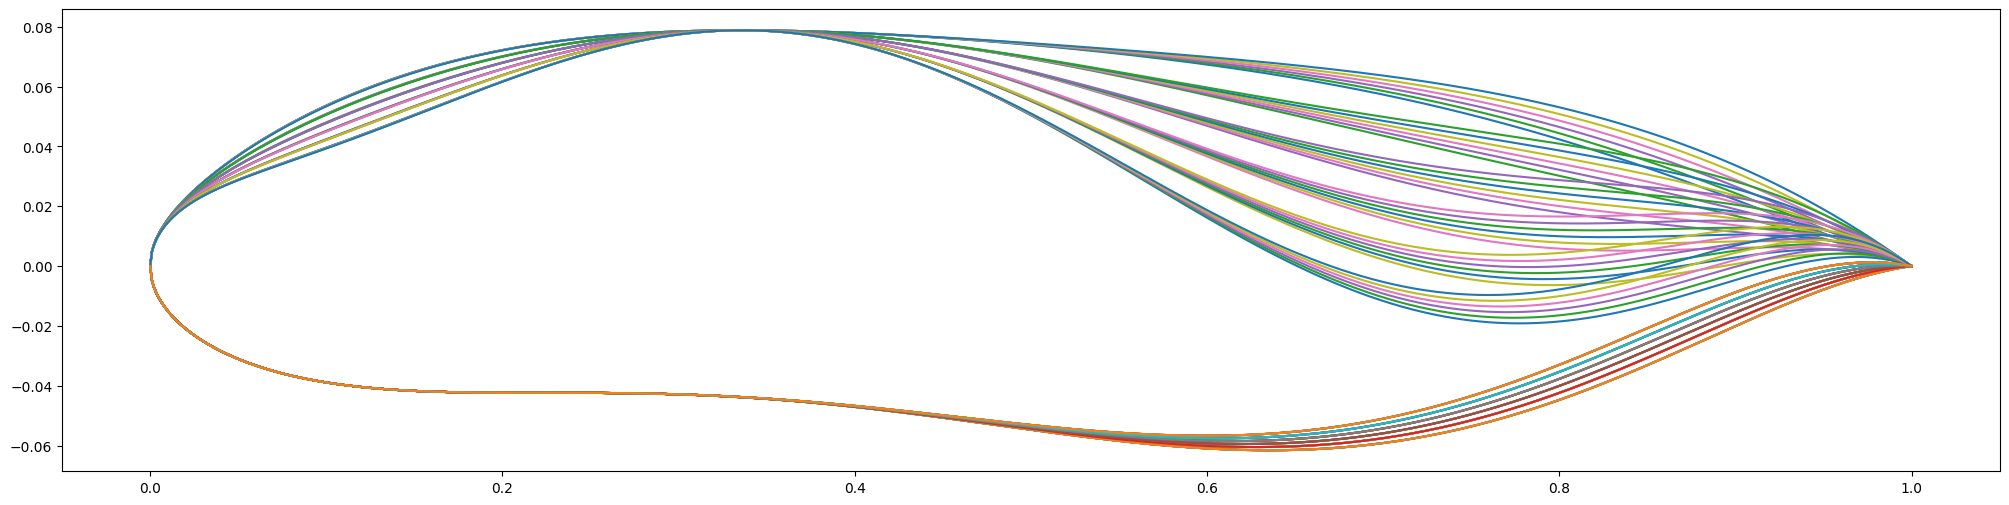

In [54]:
plt.figure(figsize=(25,6))
for p in range(90,450,60):
    for q in range(90,450,60):
        plot_combi(p,q,1)
